# LTSM Model to Predict a Stocks Next Day Close

In this mini project, we will go through the end-to-end machine learning lifecycle of developing an LTSM model to predict IBM's stock close price based off of historical prices. We utilize PyTorch and Alpha Vantage APIs (Financial Data).

In [1]:
#Dependencies
import numpy as np

import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
from torch.utils.data import Dataset
from torch.utils.data import DataLoader

import matplotlib.pyplot as plt
from matplotlib.pyplot import figure

from alpha_vantage.timeseries import TimeSeries 

print("All libraries loaded")

All libraries loaded


### Setting up the configuration for the project. 

In [2]:
config = {
    "alpha_vantage": {
        "key": 'W8QKFBHJY3BB6MF9',
        "symbol": "IBM",
        "outputsize": "full",
        "key_adjusted_close": "5. adjusted close",
    },
    "data": {
        "window_size": 20,
        "train_split_size": 0.80,
    }, 
    "plots": {
        "xticks_interval": 90, # show a date every 90 days
        "color_actual": "#001f3f",
        "color_train": "#3D9970",
        "color_val": "#0074D9",
        "color_pred_train": "#3D9970",
        "color_pred_val": "#0074D9",
        "color_pred_test": "#FF4136",
    },
    "model": {
        "input_size": 1, # since we are only using 1 feature, close price
        "num_lstm_layers": 2,
        "lstm_size": 32,
        "dropout": 0.2,
    },
    "training": {
        "device": "cpu", 
        "batch_size": 64,
        "num_epoch": 100,
        "learning_rate": 0.01,
        "scheduler_step_size": 40,
    }
}

### Getting Data From Alpha Vantage API

we collect the daily adjusted (includes: date, daily open, daily high, daily low, daily close, daily split/dividend-adjusted close, daily volume) from Alpha Vantage's daily adjusted API. Adjusted removes any artificial price turbulences due to stock splits and dividend payout events. It is generally considered an industry best practice to use split/dividend-adjusted prices instead of raw prices to model stock price movements.

https://www.crsp.org/products/documentation/crsp-calculations

In [3]:
def download_data(config):
    #implement all the api calls to times series
    ts = TimeSeries(key=config["alpha_vantage"]["key"])
    
    #Return daily adjusted (date, daily open, daily high, daily low,
    #daily close, daily split/dividend-adjusted close, daily volume)
    #time series in two objects as data and meta_data.
    data, meta_data = ts.get_daily_adjusted(config["alpha_vantage"]["symbol"], 
                                            outputsize=config["alpha_vantage"]["outputsize"])
    
    
    #create a list of all days and reverse (i.e. start at earliest)
    data_date = [date for date in data.keys()]
    data_date.reverse()
    
    #get the close prices for each data and reverse. Then store as np.array
    data_close_price = [float(data[date][config["alpha_vantage"]["key_adjusted_close"]]) for date in data.keys()]
    data_close_price.reverse()
    data_close_price = np.array(data_close_price)

    num_data_points = len(data_date)
    display_date_range = "from " + data_date[0] + " to " + data_date[num_data_points-1]
    print("Number data points", num_data_points, display_date_range)

    return data_date, data_close_price, num_data_points, display_date_range

In [4]:
# get data
data_date, data_close_price, num_data_points, display_date_range = download_data(config)

Number data points 5561 from 1999-11-01 to 2021-12-06


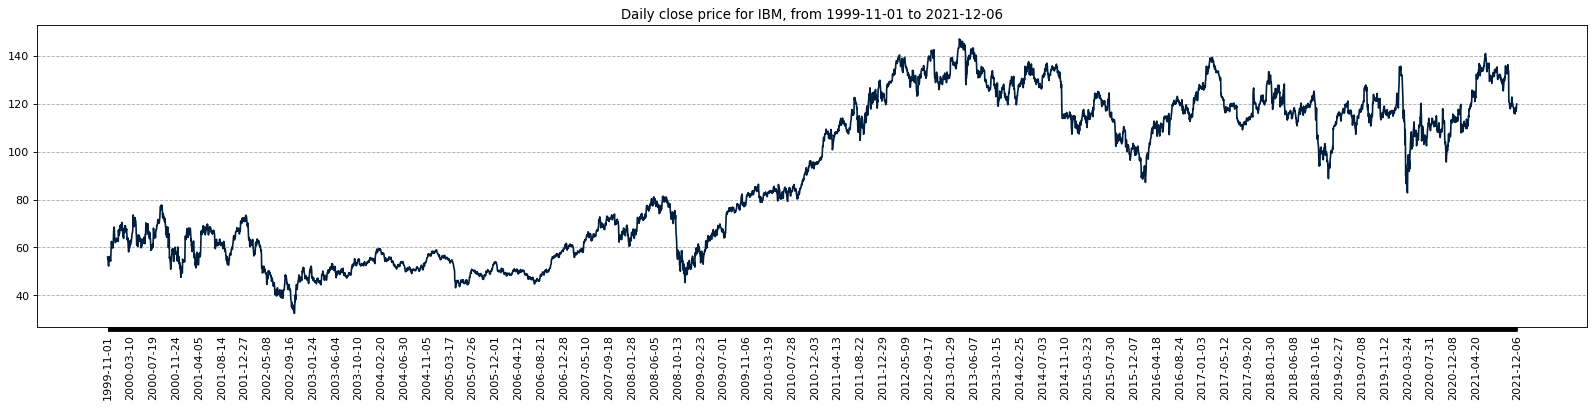

In [7]:
# plot data

fig = figure(figsize=(25, 5), dpi=80)

plt.plot(data_date, data_close_price, color=config["plots"]["color_actual"])

#display dates at an interval of 90 days
xticks = [data_date[i] if ((i%config["plots"]["xticks_interval"]==0 and (num_data_points-i) > 
                            config["plots"]["xticks_interval"]) or i==num_data_points-1) 
          else None for i in range(num_data_points)] 

x = np.arange(0,len(xticks))
plt.xticks(x, xticks, rotation='vertical')
plt.title("Daily close price for " + config["alpha_vantage"]["symbol"] + ", " + display_date_range)
plt.grid(b=None, which='major', axis='y', linestyle='--')
plt.show()

### Data Prep

Machine learning algorithms (such as our LSTM algorithm) that use gradient descent as the optimization technique require data to be scaled. This is due to the fact that the feature values in the model will affect the step size of the gradient descent if they are not all scaled, potentially skewing the LSTM model in unexpected ways.

Normalization prevents any skewing and helps the gradient descent algorithm converge more quickly by bringing the input data on the same scale and reducing its variance. Furthermore, LSTMs are intrinsically sensitive to the scale of the input data therefore it is crucial to normalize the data.

Since stock prices can range from tens to hundreds and thousands - \\$40 to \\$160 per share in the case of IBM - we will perform normalization on the stock prices to standardize the range of these values before feeding the data to the LSTM model. We rescale the data to have a mean of 0 and the standard deviation is 1.

In [8]:
class Normalizer():
    def __init__(self):
        self.mu = None
        self.sd = None

    def fit_transform(self, x):
        self.mu = np.mean(x, axis=(0), keepdims=True)
        self.sd = np.std(x, axis=(0), keepdims=True)
        normalized_x = (x - self.mu)/self.sd
        return normalized_x

    def inverse_transform(self, x):
        return (x*self.sd) + self.mu

In [9]:
# make an instance of normalizer class
scaler = Normalizer()

# perform .fit_transform method on our data_close_price (performs the normalization)
normalized_data_close_price = scaler.fit_transform(data_close_price)

In [10]:
# this is all our close prices from 1999-11-01 to 2021-11-23
normalized_data_close_price.shape

(5561,)

In this project, we will train the model to predict the 21st day's close price based on the past 20 days' close prices. The number of days, 20, was selected based on a few reasons:

- When LSTM models are used in natural language processing, the number of words in a sentence typically ranges from 15 to 20 words

- Gradient descent considerations: attempting to back-propagate across very long input sequences may result in vanishing gradients

- Longer sequences tend to have much longer training times

In [11]:
def prepare_data_x(x, window_size):
    # We want to transform the dataset into input features and output labels, the shape of our X will be (5388, 20),
    # with 5388 being the number of rows and each row containing a sequence of past 20 days' prices.
    
    # each row consists of the previous 20 days - therefore they are overlapping!!
    # the reason the number of rows is less is because the last row contains the last 20 elements of 
    # normalized_data_close_price. i.e if we go back one more we will have 19 days not 20!!
    n_row = x.shape[0] - window_size + 1
    
    # to produce this we have to use strides - which defines how many bits must be skipped in memory to reach the 
    # next elm of a np.array!
    output = np.lib.stride_tricks.as_strided(x, shape=(n_row, window_size), strides=(x.strides[0], x.strides[0]))
    return output[:-1], output[-1]


def prepare_data_y(x, window_size):
    
    # use the next day as label
    output = x[window_size:]
    return output

In [12]:
data_x, data_x_unseen = prepare_data_x(normalized_data_close_price, window_size=config["data"]["window_size"])
data_y = prepare_data_y(normalized_data_close_price, window_size=config["data"]["window_size"])

### Explaination of the data format

In [13]:
normalized_data_close_price.shape

(5561,)

##### Today's price

In [14]:
#todays price (because we reversed:earliest to latest)
normalized_data_close_price[-1]

0.9333171859495503

In [15]:
# the previous 20 days from todays price (last row of data_x)
data_x[-1]

array([0.99759232, 1.02643116, 0.96286168, 0.94306058, 0.9446321 ,
       0.90345839, 0.90062966, 0.88774323, 0.8751711 , 0.83116866,
       0.81199617, 0.8251969 , 0.8352546 , 0.83336878, 0.80445289,
       0.88900044, 0.844998  , 0.83934054, 0.83871193, 0.89968675])

In [16]:
# todays price stored as the label for y (last row of data_y)
data_y[-1]

0.9333171859495503

##### Yesterday's Price

In [17]:
#NOW LETS LOOK AT YESTERDAYS PRICE!

# yesterdays price
normalized_data_close_price[-2]

0.899686747761406

In [18]:
# the previous 20 days from yesterdays price (last but one row of data_x)
data_x[-2]

#NOTE: the overlap!! (in the 20days from TODAYS price!)

array([0.9120061 , 0.99759232, 1.02643116, 0.96286168, 0.94306058,
       0.9446321 , 0.90345839, 0.90062966, 0.88774323, 0.8751711 ,
       0.83116866, 0.81199617, 0.8251969 , 0.8352546 , 0.83336878,
       0.80445289, 0.88900044, 0.844998  , 0.83934054, 0.83871193])

In [19]:
# yesterdays price stored as the label for y (last but one row of data_y)
data_y[-2]

0.899686747761406

### Split the dataset into training and validation

We also split the dataset into two parts, for training and validation. We split the data into 80:20 - 80% of the data is used for training, with the remaining 20% for validating our model's performance in predicting future prices.

In [20]:
# split dataset

split_index = int(data_y.shape[0]*config["data"]["train_split_size"])
data_x_train = data_x[:split_index]
data_x_val = data_x[split_index:]
data_y_train = data_y[:split_index]
data_y_val = data_y[split_index:]

print(data_x_train.shape)
print(data_x_val.shape)
print(data_y_train.shape)
print(data_y_val.shape)

(4432, 20)
(1109, 20)
(4432,)
(1109,)


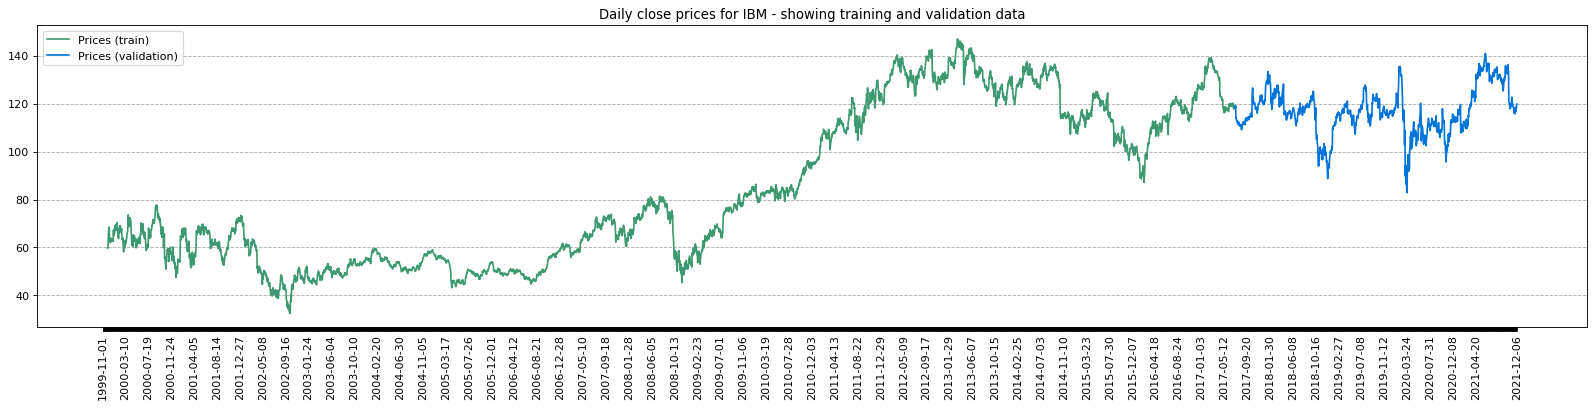

In [21]:
# prepare data for plotting

to_plot_data_y_train = np.zeros(num_data_points)
to_plot_data_y_val = np.zeros(num_data_points)

to_plot_data_y_train[config["data"]["window_size"]:split_index+config["data"]
                     ["window_size"]] = scaler.inverse_transform(data_y_train)

to_plot_data_y_val[split_index+config["data"]["window_size"]:] = scaler.inverse_transform(data_y_val)

to_plot_data_y_train = np.where(to_plot_data_y_train == 0, None, to_plot_data_y_train)
to_plot_data_y_val = np.where(to_plot_data_y_val == 0, None, to_plot_data_y_val)

## plots

fig = figure(figsize=(25, 5), dpi=80)
fig.patch.set_facecolor((1.0, 1.0, 1.0))
plt.plot(data_date, to_plot_data_y_train, label="Prices (train)", color=config["plots"]["color_train"])
plt.plot(data_date, to_plot_data_y_val, label="Prices (validation)", color=config["plots"]["color_val"])
xticks = [data_date[i] if ((i%config["plots"]["xticks_interval"]==0 and (num_data_points-i) > 
                            config["plots"]["xticks_interval"]) or i==num_data_points-1) 
          else None for i in range(num_data_points)] # make x ticks nice
x = np.arange(0,len(xticks))
plt.xticks(x, xticks, rotation='vertical')
plt.title("Daily close prices for " + config["alpha_vantage"]["symbol"] + " - showing training and validation data")
plt.grid(b=None, which='major', axis='y', linestyle='--')
plt.legend()
plt.show()

### Creating Dataset Objects (DataLoader) - Pytorch

We will train our models using the PyTorch framework. At the heart of PyTorch's data loading utility is the DataLoader class, an efficient data generation scheme that leverages the full potential of your computer's Graphics Processing Unit (GPU) during the training process where applicable. 

DataLoader requires the Dataset object to define the loaded data. Dataset is a map-style dataset that implements the __getitem__() and __len__() protocols, and represents a map from indices to data samples.

In [22]:
# creating our dataset object - through a Subclass of the superclass Dataset

class TimeSeriesDataset(Dataset):
    def __init__(self, x, y):
        super(TimeSeriesDataset, self).__init__()
        
        # in our case, we have only 1 feature (the date), so we need to convert x into [batch_size, sequence, features] 
        # for LSTM
        x = np.expand_dims(x, 2) 
        self.x = x.astype(np.float32)
        self.y = y.astype(np.float32)
        
    def __len__(self):
        return len(self.x)

    def __getitem__(self, idx):
        return (self.x[idx], self.y[idx])

In [23]:
dataset_train = TimeSeriesDataset(data_x_train, data_y_train)
dataset_val = TimeSeriesDataset(data_x_val, data_y_val)

print("Train data shape", dataset_train.x.shape, dataset_train.y.shape)
print("Validation data shape", dataset_val.x.shape, dataset_val.y.shape)

#now we send our dataset object into the dataloader method which speeds up processing and batches up!
train_dataloader = DataLoader(dataset_train, batch_size=config["training"]["batch_size"], shuffle=True)
val_dataloader = DataLoader(dataset_val, batch_size=config["training"]["batch_size"], shuffle=True)

Train data shape (4432, 20, 1) (4432,)
Validation data shape (1109, 20, 1) (1109,)


## Defining our LSTM Model

With the training and evaluation data now fully normalized and prepared, we are ready to build our LSTM model!

LSTM is a specialized artificial neural network architecture that can "memorize" patterns from historical sequences of data and extrapolate such patterns for future events. Specifically, it belongs to a group of artificial neural networks called Recurring Neural Networks (RNNs).

LSTM is a popular artificial neural network because it manages to overcome many technical limitations of RNNs. For example, RNNs fail to learn when the data sequence is greater than 10 due to the vanishing gradients problem, where the gradients are vanishingly small, effectively preventing the model from learning. LSTMs can learn long sequences of data by enforcing constant error flow through self-connected hidden layers, which contain memory cells and corresponding gate units.

https://colah.github.io/posts/2015-08-Understanding-LSTMs/

The artificial neural network will have three main layers, with each layer designed with a specific logical purpose:

❚ linear layer 1 (linear_1): to map input values into a high dimensional feature space, transforming the features for the LSTM layer

❚ LSTM (lstm): to learn the data in sequence

❚ linear layer 2 (linear_2): to produce the predicted value based on LSTM's output

We also add Dropout, where randomly selected artificial neurons are ignored during training, therefore regularizing the network to prevent overfitting and improving overall model performance. As an optional step, we also initialize the LSTM's model weights, as some researchers have observed that it could help the model learn more efficiently.

In [24]:
class LSTMModel(nn.Module):
    # nn.Module is the base class for all NN's in Pytorch
    def __init__(self, input_size=1, hidden_layer_size=32, num_layers=2, output_size=1, dropout=0.2):
        super(LSTMModel, self).__init__()
        
        #Defining the layers which will be used in our model!
        
        self.hidden_layer_size = hidden_layer_size
        # apply a linear transformation 
        self.linear_1 = nn.Linear(input_size, hidden_layer_size)
        # ReLU activation Layer
        self.relu = nn.ReLU()
        # multi-layer long short-term memory (LSTM) RNN to an input sequence.
        self.lstm = nn.LSTM(hidden_layer_size, hidden_size=self.hidden_layer_size, num_layers=num_layers, batch_first=True)
        # apply dropout layer - for regularization
        self.dropout = nn.Dropout(dropout)
        # finish with a linear transformation
        self.linear_2 = nn.Linear(num_layers*hidden_layer_size, output_size)
        
        self.init_weights()

    def init_weights(self):
        for name, param in self.lstm.named_parameters():
            if 'bias' in name:
                 nn.init.constant_(param, 0.0)
            elif 'weight_ih' in name:
                 nn.init.kaiming_normal_(param)
            elif 'weight_hh' in name:
                 nn.init.orthogonal_(param)

    def forward(self, x):
        batchsize = x.shape[0]
        
        #Forward Method - Impliments our (LSTM) Model
        
        # layer 1
        x = self.linear_1(x)
        x = self.relu(x)
        
        # LSTM layer
        lstm_out, (h_n, c_n) = self.lstm(x)

        # reshape output from hidden cell into [batch, features] for `linear_2`
        x = h_n.permute(1, 0, 2).reshape(batchsize, -1) 
        
        # layer 2
        x = self.dropout(x)
        predictions = self.linear_2(x)
        return predictions[:,-1]

### Model Training

The LSTM model learns by iteratively making predictions given the training data X. We use mean squared error as the cost function, which measures the difference between the predicted values and the actual values. When the model is making bad predictions, the error value returned by the cost function will be relatively high. The model will fine-tune its weights through backpropagation, improving its ability to make better predictions. Learning stops when the algorithm achieves an acceptable level of performance, where the error value returned by the cost function on the validation dataset is no longer showing incremental improvements.

We use the Adam optimizer that updates the model's parameters based on the learning rate through its step() method. This is how the model learns and fine-tunes its predictions. The learning rate controls how quickly the model converges. A learning rate that is too high can cause the model to converge too quickly to a suboptimal solution, whereas smaller learning rates require more training iterations and may result in prolonged duration for the model to find the optimal solution. We also use the StepLR scheduler to reduce the learning rate during the training process. 

we could also try the ReduceLROnPlateau scheduler, which reduces the learning rate when a cost function has stopped improving for a "patience" number of epochs. Choosing the proper learning rate for your project is both art and science, and is a heavily researched topic in the machine learning community.

In [25]:
def run_epoch(dataloader, is_training=False):
    epoch_loss = 0

    if is_training:
        model.train()
    else:
        model.eval()

    for idx, (x, y) in enumerate(dataloader):
        if is_training:
            optimizer.zero_grad()

        batchsize = x.shape[0]

        x = x.to(config["training"]["device"])
        y = y.to(config["training"]["device"])

        out = model(x)
        loss = criterion(out.contiguous(), y.contiguous())

        if is_training:
            loss.backward()
            optimizer.step()

        epoch_loss += (loss.detach().item() / batchsize)

    lr = scheduler.get_last_lr()[0]

    return epoch_loss, lr

In [28]:
# Instantate the Model
model = LSTMModel(input_size=config["model"]["input_size"], hidden_layer_size=config["model"]["lstm_size"], num_layers=config["model"]["num_lstm_layers"], output_size=1, dropout=config["model"]["dropout"])
model = model.to(config["training"]["device"])

#define loss fun, optimizer(Adam) and learning rate
criterion = nn.MSELoss()
optimizer = optim.Adam(model.parameters(), lr=config["training"]["learning_rate"], betas=(0.9, 0.98), eps=1e-9)
scheduler = optim.lr_scheduler.StepLR(optimizer, step_size=config["training"]["scheduler_step_size"], gamma=0.1)

# run over 100 epochs
for epoch in range(config["training"]["num_epoch"]):
    loss_train, lr_train = run_epoch(train_dataloader, is_training=True)
    loss_val, lr_val = run_epoch(val_dataloader)
    scheduler.step()
    
    if epoch % 10 == 0:
        print('Epoch[{}/{}] | loss train:{:.6f}, test:{:.6f} | lr:{:.6f}'
                  .format(epoch, config["training"]["num_epoch"], loss_train, loss_val, lr_train))

Epoch[0/100] | loss train:0.071489, test:0.003500 | lr:0.010000
Epoch[10/100] | loss train:0.008431, test:0.001840 | lr:0.010000
Epoch[20/100] | loss train:0.008534, test:0.001196 | lr:0.010000
Epoch[30/100] | loss train:0.008688, test:0.001436 | lr:0.010000
Epoch[40/100] | loss train:0.006827, test:0.001159 | lr:0.001000
Epoch[50/100] | loss train:0.006632, test:0.001227 | lr:0.001000
Epoch[60/100] | loss train:0.006640, test:0.001111 | lr:0.001000
Epoch[70/100] | loss train:0.006708, test:0.001295 | lr:0.001000
Epoch[80/100] | loss train:0.006397, test:0.001152 | lr:0.000100
Epoch[90/100] | loss train:0.006159, test:0.001117 | lr:0.000100


Loss train gives an idea of how well the model is learning, while loss test shows how well the model generalizes to the validation dataset. A well-trained model is identified by a training and validation loss that decreases to the point of negligible differences between the two final loss values (at this stage, we say the model has "converged"). Generally, the loss values of the model will be lower on the training than on the validation dataset.

### Model Evaluation

To visually inspect our model's performance, we will use the newly trained model to make predictions on the training and validation datasets we've created earlier.

If we see that the model can predict values that closely mirror the training dataset, it shows that the model managed to memorize the data. And if the model can predict values that resemble the validation dataset, it has managed to learn the patterns in our sequential data and generalize the patterns to unseen data points.

In [29]:
# here we re-initialize dataloader so the data doesn't shuffled, so we can plot the values by date

train_dataloader = DataLoader(dataset_train, batch_size=config["training"]["batch_size"], shuffle=False)
val_dataloader = DataLoader(dataset_val, batch_size=config["training"]["batch_size"], shuffle=False)

model.eval()

# predict on the training data, to see how well the model managed to learn and memorize

predicted_train = np.array([])

for idx, (x, y) in enumerate(train_dataloader):
    x = x.to(config["training"]["device"])
    out = model(x)
    out = out.cpu().detach().numpy()
    predicted_train = np.concatenate((predicted_train, out))

# predict on the validation data, to see how the model does

predicted_val = np.array([])

for idx, (x, y) in enumerate(val_dataloader):
    x = x.to(config["training"]["device"])
    out = model(x)
    out = out.cpu().detach().numpy()
    predicted_val = np.concatenate((predicted_val, out))


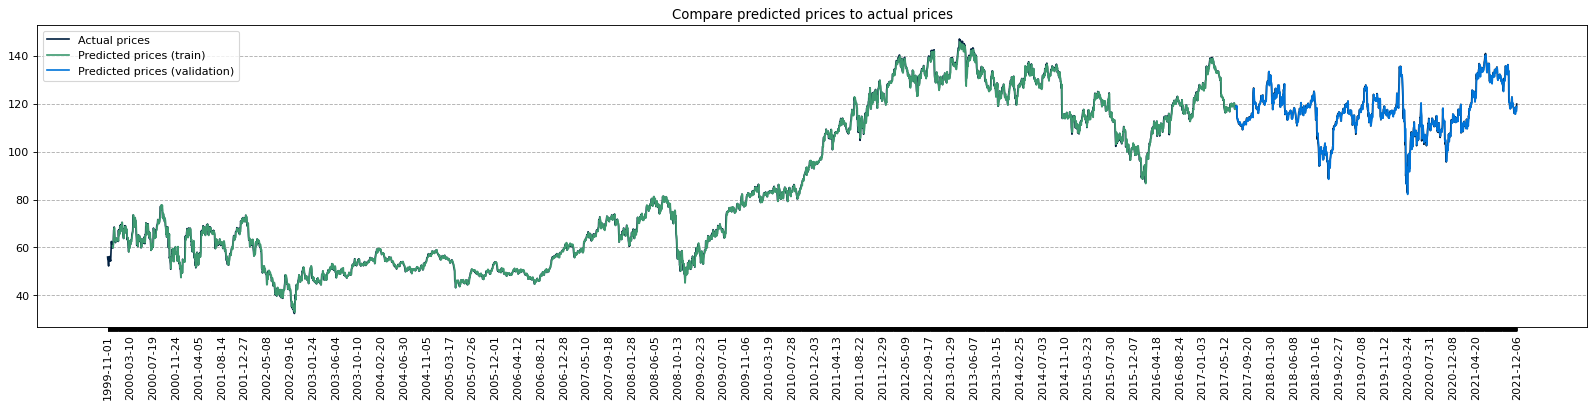

In [30]:
# prepare data for plotting

to_plot_data_y_train_pred = np.zeros(num_data_points)
to_plot_data_y_val_pred = np.zeros(num_data_points)

to_plot_data_y_train_pred[config["data"]["window_size"]:split_index+config["data"]["window_size"]] = scaler.inverse_transform(predicted_train)
to_plot_data_y_val_pred[split_index+config["data"]["window_size"]:] = scaler.inverse_transform(predicted_val)

to_plot_data_y_train_pred = np.where(to_plot_data_y_train_pred == 0, None, to_plot_data_y_train_pred)
to_plot_data_y_val_pred = np.where(to_plot_data_y_val_pred == 0, None, to_plot_data_y_val_pred)

# plots

fig = figure(figsize=(25, 5), dpi=80)
fig.patch.set_facecolor((1.0, 1.0, 1.0))
plt.plot(data_date, data_close_price, label="Actual prices", color=config["plots"]["color_actual"])
plt.plot(data_date, to_plot_data_y_train_pred, label="Predicted prices (train)", color=config["plots"]["color_pred_train"])
plt.plot(data_date, to_plot_data_y_val_pred, label="Predicted prices (validation)", color=config["plots"]["color_pred_val"])
plt.title("Compare predicted prices to actual prices")
xticks = [data_date[i] if ((i%config["plots"]["xticks_interval"]==0 and (num_data_points-i) > config["plots"]["xticks_interval"]) or i==num_data_points-1) else None for i in range(num_data_points)] # make x ticks nice
x = np.arange(0,len(xticks))
plt.xticks(x, xticks, rotation='vertical')
plt.grid(b=None, which='major', axis='y', linestyle='--')
plt.legend()
plt.show()

From our results, we can see that the model has managed to learn and predict on both training (green) and validation (blue) datasets very well, as the "Predicted prices" lines significantly overlap with the "Actual prices" values.

Let's zoom into the chart and look closely at the blue "Predicted price (validation)" segment by comparing it against the actual prices values.

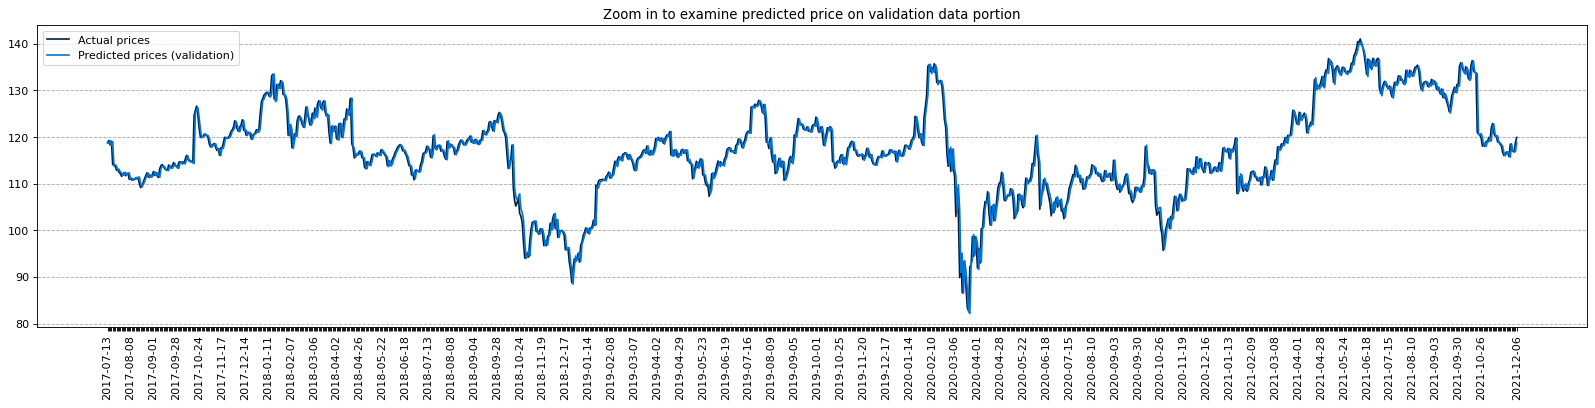

In [31]:
# prepare data for plotting the zoomed in view of the predicted prices (on validation set) vs. actual prices

to_plot_data_y_val_subset = scaler.inverse_transform(data_y_val)
to_plot_predicted_val = scaler.inverse_transform(predicted_val)
to_plot_data_date = data_date[split_index+config["data"]["window_size"]:]

# plots

fig = figure(figsize=(25, 5), dpi=80)
fig.patch.set_facecolor((1.0, 1.0, 1.0))
plt.plot(to_plot_data_date, to_plot_data_y_val_subset, label="Actual prices", color=config["plots"]["color_actual"])
plt.plot(to_plot_data_date, to_plot_predicted_val, label="Predicted prices (validation)", color=config["plots"]["color_pred_val"])
plt.title("Zoom in to examine predicted price on validation data portion")
xticks = [to_plot_data_date[i] if ((i%int(config["plots"]["xticks_interval"]/5)==0 and (len(to_plot_data_date)-i) > config["plots"]["xticks_interval"]/6) or i==len(to_plot_data_date)-1) else None for i in range(len(to_plot_data_date))] # make x ticks nice
xs = np.arange(0,len(xticks))
plt.xticks(xs, xticks, rotation='vertical')
plt.grid(b=None, which='major', axis='y', linestyle='--')
plt.legend()
plt.show()

### Predicting Future Prices!

By now, we have trained an LSTM model that can (fairly accurately) predict the next day's price based on the past 20 days' close prices. Let's supply the past 20 days' close prices to the model and see what it predicts for the next trading day (i.e., the future!).

In [32]:
# predict the closing price of the next trading day

model.eval()

# this is the data type and shape required, [batch, sequence, feature]
x = torch.tensor(data_x_unseen).float().to(config["training"]["device"]).unsqueeze(0).unsqueeze(2) 

prediction = model(x)
prediction = prediction.cpu().detach().numpy()

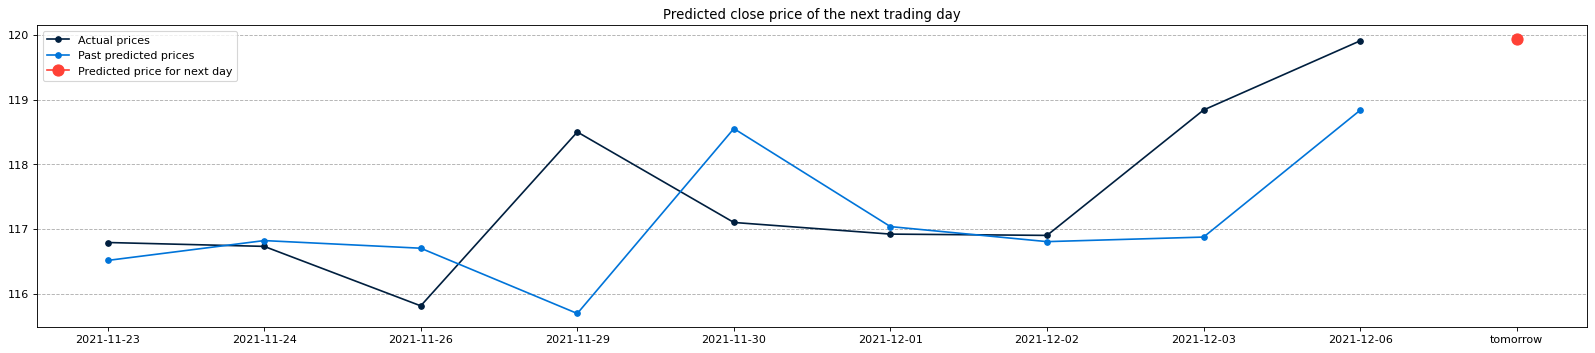

Predicted close price of the next trading day: 119.94


In [33]:
# prepare plots

plot_range = 10
to_plot_data_y_val = np.zeros(plot_range)
to_plot_data_y_val_pred = np.zeros(plot_range)
to_plot_data_y_test_pred = np.zeros(plot_range)

to_plot_data_y_val[:plot_range-1] = scaler.inverse_transform(data_y_val)[-plot_range+1:]
to_plot_data_y_val_pred[:plot_range-1] = scaler.inverse_transform(predicted_val)[-plot_range+1:]

to_plot_data_y_test_pred[plot_range-1] = scaler.inverse_transform(prediction)

to_plot_data_y_val = np.where(to_plot_data_y_val == 0, None, to_plot_data_y_val)
to_plot_data_y_val_pred = np.where(to_plot_data_y_val_pred == 0, None, to_plot_data_y_val_pred)
to_plot_data_y_test_pred = np.where(to_plot_data_y_test_pred == 0, None, to_plot_data_y_test_pred)

# plot

plot_date_test = data_date[-plot_range+1:]
plot_date_test.append("tomorrow")

fig = figure(figsize=(25, 5), dpi=80)
fig.patch.set_facecolor((1.0, 1.0, 1.0))
plt.plot(plot_date_test, to_plot_data_y_val, label="Actual prices", marker=".", markersize=10, color=config["plots"]["color_actual"])
plt.plot(plot_date_test, to_plot_data_y_val_pred, label="Past predicted prices", marker=".", markersize=10, color=config["plots"]["color_pred_val"])
plt.plot(plot_date_test, to_plot_data_y_test_pred, label="Predicted price for next day", marker=".", markersize=20, color=config["plots"]["color_pred_test"])
plt.title("Predicted close price of the next trading day")
plt.grid(b=None, which='major', axis='y', linestyle='--')
plt.legend()
plt.show()

print("Predicted close price of the next trading day:", round(to_plot_data_y_test_pred[plot_range-1], 2))

The red dot in the graph is what our model predicts for IBM's close price on the next trading day.